In [1]:
import os
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


#api info: https://open-platform.theguardian.com/documentation/

keyword = "Justin AND Trudeau"
from_date = "2018-01-01"
end_date = date.today()
my_path = "XXXX" #path for saving figures
api_key = "XXXX" #get key here: https://open-platform.theguardian.com/access/


######---for working with config-file---#############
# from configparser import ConfigParser
# config = ConfigParser()
# config.read("config.ini")
# from_date = config.get("DEFAULT", "from_date")
# end_date = date.today()
# keyword = config.get("DEFAULT", "keyword")
# my_path = config.get("DEFAULT", "path") + "keyword_%s\\" %keyword
# api_key = config.get("DEFAULT", "api_key")



API_ENDPOINT = "http://content.guardianapis.com/search"
page_size = 200 #max=200

parameter = {
    "q": keyword,
    "from-date": from_date,
    "order-by": "oldest",
    "show-fields": "none",
    "page-size": page_size,
    "currentPage": "all",
    "api-key": api_key,
    "page": 1
} 
response = requests.get(API_ENDPOINT, parameter)
data_json = response.json()
      
total_count = data_json["response"]["total"] #Anzahl der Artikel
total_pages = data_json["response"]["pages"] #Anzahl der Pages
print(total_count,"gefundene Artikel mit keyword:", keyword, "Zeitraum:",from_date,"-",end_date)

555 gefundene Artikel mit keyword: Justin AND Trudeau Zeitraum: 2018-01-01 - 2020-03-02


In [2]:
data = pd.DataFrame(index = range(total_count), columns = ["date","section","url"])
n=0
#get_data for every page, exept last page
for pages in range(total_pages-1):
    pages +=1
    parameter["page"] = pages 
    response = requests.get(API_ENDPOINT, parameter)
    data_json = response.json()
    
    for i in range(page_size):
        #time
        date = data_json["response"]["results"][i]["webPublicationDate"]
        date, time = date.split("T")
        date = datetime.strptime(date, "%Y-%m-%d")
        data.at[n+i,"date"] = date
        #section
        data.at[n+i,"section"] = data_json["response"]["results"][i]["sectionName"]
        #url
        data.at[n+i,"url"] = data_json["response"]["results"][i]["webUrl"]
    n=pages*page_size
    
#get_data for last page
parameter["page"] = total_pages #last page
response = requests.get(API_ENDPOINT, parameter)
data_json = response.json()

rest = total_count -((total_pages-1)*page_size)
for i in range(rest):
    #time
    date = data_json["response"]["results"][i]["webPublicationDate"]
    date, time = date.split("T")
    date = datetime.strptime(date, "%Y-%m-%d")
    data.at[n+i,"date"] = date
    #section
    data.at[n+i,"section"] = data_json["response"]["results"][i]["sectionName"]
    #url
    data.at[n+i,"url"] = data_json["response"]["results"][i]["webUrl"]


Im Schnitt werden 0.7 Artikel pro Tag mit dem Keyword Justin AND Trudeau veröffentlicht.

Die section: World news ist mit 272 Artikeln die am häufigsten vorkommende section.

      section  count  percent
0  World news    272     0.49
1     US news     76     0.14
2     Opinion     50     0.09
3    Politics     27     0.05
4    Business     26     0.05


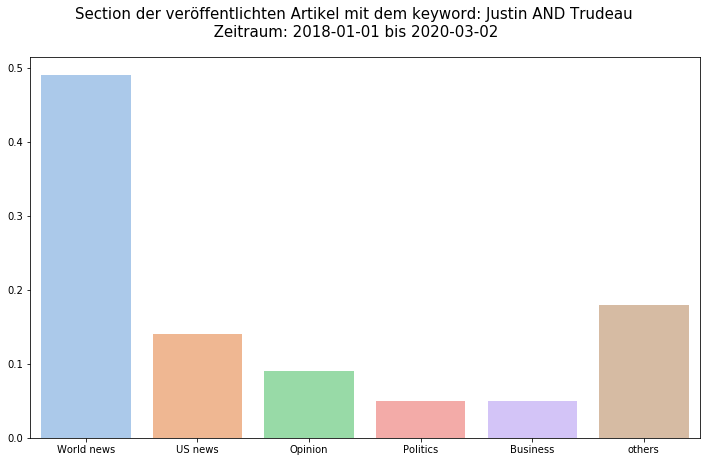

In [3]:
#dataframe with number of published articles per day
date_freq = data["date"].value_counts()
date_freq = pd.DataFrame({"date":date_freq.index, "count":date_freq.values})
date_freq = date_freq.sort_values(by="date")

#fill missing dates (=days with 0 published articles) 
#to avoid bias in graphical representation and calculation of averages
r = pd.date_range(start=date_freq.date.min(), end=end_date)
date_freq_full = date_freq.set_index("date").reindex(r).fillna(0.0).rename_axis("date").reset_index()

#calculate average of published articles per day (including days with 0 published articles)
mean = round(date_freq_full["count"].mean(),2)
print("\nIm Schnitt werden",mean,"Artikel pro Tag mit dem Keyword",keyword,"veröffentlicht.\n")

#In which section are the most articles published?
section_freq = data["section"].value_counts()
print("Die section:",section_freq.index[0], "ist mit",section_freq[0],"Artikeln die am häufigsten vorkommende section.\n" )
section_freq = pd.DataFrame({"section":section_freq.index, "count":section_freq.values, "percent":section_freq.values/total_count})
section_freq = section_freq.round({"percent": 2})
print(section_freq.head())

#generate pie chart
if len(section_freq)>5:  
    labels = section_freq["section"].head(5).values
    sizes = section_freq["percent"].head(5).values
    labels = np.append(labels, "others")
    sizes = np.append(sizes, 1 - sum(section_freq["percent"].head(5).values))

else:
    labels = section_freq["section"].values
    sizes = section_freq["percent"].values

fig, ax = plt.subplots(ncols=1,figsize=(12,7))
fig.suptitle("Section der veröffentlichten Artikel mit dem keyword: "+str(keyword)+ "\n Zeitraum: "+str(from_date)+" bis "+str(end_date),size=15)
#ax[0].pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
ax = sns.barplot(x = labels, y=sizes, palette="pastel")

#generate path and save fig as pdf     
try: 
    os.mkdir(my_path)  
except OSError:
       plt.savefig(my_path + "section_%s.pdf" %end_date)
plt.savefig(my_path + "section_%s.pdf" %end_date)
plt.show()

#99% Percentile to define outliers
percentil = np.percentile(date_freq_full["count"], 99)
max_count = date_freq_full[date_freq_full["count"]>percentil]

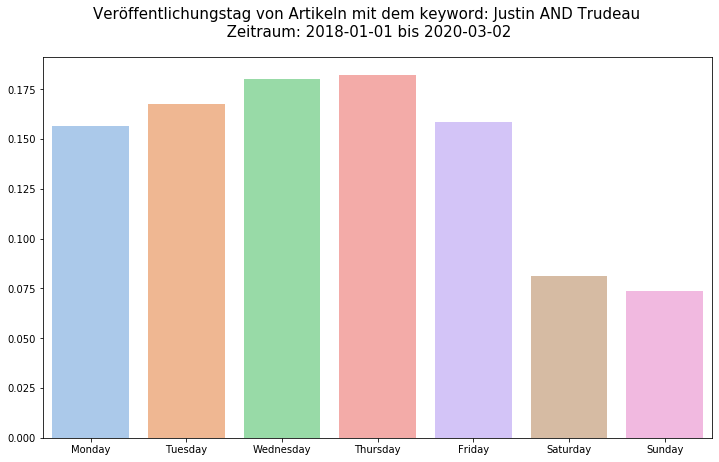

In [4]:
#on which weekday are the most articles published?
days = {}
for day in range(len(date_freq_full)):
        weekday=date_freq_full["date"][day].strftime("%A")
        if not weekday in days:
            days[weekday] = date_freq_full["count"][day]
        else:
            days[weekday] += date_freq_full["count"][day]
weekday_data = pd.DataFrame(index = range(len(days)), columns = ["weekday","count","percent"])           
i=0    
for weekday in days:
    weekday_data["count"][i]=days[weekday]
    weekday_data["weekday"][i]=weekday
    weekday_data["percent"][i]=days[weekday]/total_count 
    i+=1
labels = weekday_data["weekday"].values
sizes = weekday_data["percent"].values



fig, ax = plt.subplots(ncols=1,figsize=(12,7))
fig.suptitle("Veröffentlichungstag von Artikeln mit dem keyword: "+str(keyword)+ "\n Zeitraum: "+str(from_date)+" bis "+str(end_date),size=15)
# ax.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
ax = sns.barplot(x = labels, y=sizes, palette="pastel")


#generate path and save fig as pdf     
try: 
    os.mkdir(my_path)  
except OSError:
       plt.savefig(my_path + "weekday_%s.pdf" %end_date)
plt.savefig(my_path + "weekday_%s.pdf" %end_date)
plt.show() 


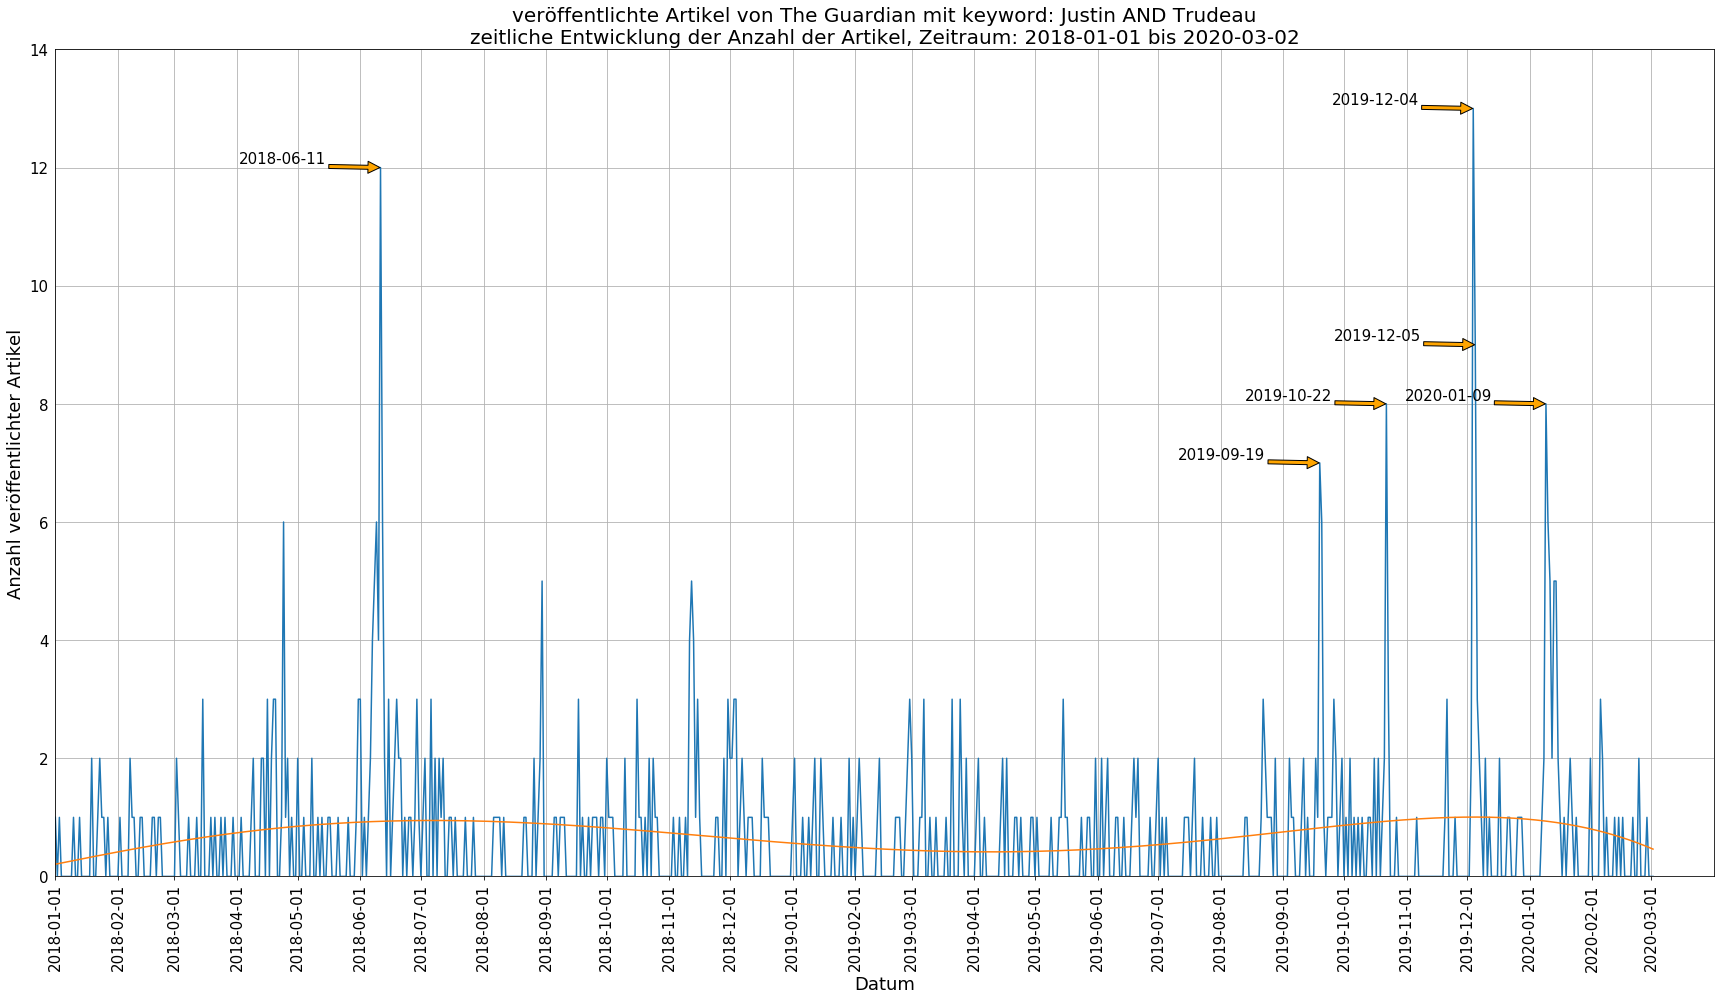

In [5]:
plt.figure(figsize=(24,14))
#plot line
plt.plot_date(date_freq_full["date"], date_freq_full["count"],linestyle="solid", marker="None")
plt.title("veröffentlichte Artikel von The Guardian mit keyword: "+str(keyword)+ "\nzeitliche Entwicklung der Anzahl der Artikel, Zeitraum: "+str(from_date)+" bis "+str(end_date),size=20)

#plot smoth line
list_x = range(0,date_freq_full["date"].count())
list_y = date_freq_full["count"].tolist()
poly = np.polyfit(list_x,list_y,5)
poly_y = np.poly1d(poly)(list_x)
plt.plot(date_freq_full["date"],poly_y)

plt.ylabel("Anzahl veröffentlichter Artikel",size=18)
plt.xlabel("Datum",size=18)
plt.grid(True)
plt.tick_params(which="both",top=False,left=False,right=False,bottom=True) 
plt.xticks(rotation=90)
plt.tick_params(labelsize=15)
plt.xticks(np.arange(from_date, end_date+timedelta(days=30), dtype="datetime64[M]")) 
plt.ylim(0, date_freq["count"].max(axis=0)+1)
plt.xlim(from_date,end_date+timedelta(days=30))

#generate mark for highest count
for index, row in max_count.iterrows():
    date = row["date"]
    date = date.strftime("%Y-%m-%d")
    count = row["count"]
    plt.annotate(s=date, xy=(date, count), xytext=(row["date"]-timedelta(days=70),count+0.07),size=15,
            arrowprops=dict(facecolor="orange", shrink=0.01),
            )
plt.tight_layout()    
#generate path and save fig as pdf     
try: 
    os.mkdir(my_path)  
except OSError:
       plt.savefig(my_path + "report_%s.pdf" %end_date)
plt.savefig(my_path + "report_%s.pdf" %end_date)
plt.show()